# Assignment #4

#### Urban Informatics for Smart, Sustainable Cities
#### NYU - Spring 2017

### Author: Avikal Somvanshi


1. Clean and plot the data for the individual sensors provided;
2. Describe the daily patterns that emerge;
3. Identify anomalous activity;
4. Link the sensor data back to city administrative records to identify possible correlations or causal relationships.
-For air quality, you should examine the correlation between particular matter concentrations and temperature, humidity, and land use.
-For noise, you should analyze the relationship (If any) between noise level readings, 311 complaints about noise, and land use.

##### Attached is the sensor data for luminosity (in Lux), particulate concentration (particle count per 0.01 cubic feet), and noise (sound pressure level in dB). The dataset includes readings for four (4) sensors in Red Hook from June 2016.

#### sensor_0 : RHI roof (at corner of Hicks and W 9th streets, elevation approx. 8m) - 767 Hicks St, Brooklyn, NY 11231
#### sensor_3 : RHI entrance (on Hicks street at street level) - 767 Hicks St, Brooklyn, NY 11231 (40.6767795, -74.0044647)
#### sensor_2 : TechLab (at ground level) - 106 Ferris St (40.6779630, -74.0176610)
#### sensor_4 : PioneerWorks roof (elevation approx. 15m) - 159 Pioneer St, Brooklyn, NY 11231 (	40.6792043,  -74.0121745)

In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.stats
import sys
import datetime
import zipfile
import os
from geopandas import GeoDataFrame
import geopandas as gpd
import shapely as shp
import statsmodels.formula.api as smf
from shapely.geometry import Point
%matplotlib inline 

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
#uploaing sensor data
data = pd.read_csv('data/LuxDustNoise_summarized_4hour_0719.csv')
data['dt'] = pd.to_datetime(data.dt)
data.head()

,dt,sensor,lux,con,spl
0,2016-06-21 00:00:00,sensor_0,0.0,2834.03125,66.308479
1,2016-06-21 00:00:00,sensor_2,0.0,1691.99625,70.375943
2,2016-06-21 00:00:00,sensor_3,0.0,1686.44125,76.235738
3,2016-06-21 00:00:00,sensor_4,0.0,2324.65875,70.652334
4,2016-06-21 04:00:00,sensor_0,3213.5,2748.28875,81.467436


In [3]:
data.tail()

,dt,sensor,lux,con,spl
481,2016-07-11 12:00:00,sensor_4,24739.125000,17538.622500,73.268664
482,2016-07-11 16:00:00,sensor_0,10537.666667,1854.351667,75.821609
483,2016-07-11 16:00:00,sensor_2,2671.666667,1998.335000,76.426254
484,2016-07-11 16:00:00,sensor_3,3664.500000,1905.743333,76.577476
485,2016-07-11 16:00:00,sensor_4,11581.166667,6097.670000,73.657495


In [4]:
#scraping weather data from wunderground.com
#data1 = pd.DataFrame()
#for j in range (6,8):
    #for i in range (1,32):
       # weat = pd.read_csv('https://www.wunderground.com/history/airport/KJRB/2016/' + str(j) + '/' + str(i) + '/DailyHistory.html?req_city=Brooklyn&req_state=NY&req_statename=New+York&reqdb.zip=11231&reqdb.magic=1&reqdb.wmo=03772&MR=1&format=1')
        #data1 = pd.concat([data1, weat])

#data1.to_csv('data/weather.csv')

In [5]:
#loading weather data
weather = pd.read_csv('data/weather.csv')
weather.drop(weather.index[[4435]], inplace=True)
weather = weather[['dt', 'TemperatureF', 'Humidity']]
weather['dt'] = pd.to_datetime(weather.dt)
weather.head()

,dt,TemperatureF,Humidity
0,2016-01-06 04:35:00,73.4,83
1,2016-01-06 04:55:00,73.4,78
2,2016-01-06 05:00:00,71.6,83
3,2016-01-06 05:35:00,71.6,83
4,2016-01-06 05:55:00,71.6,83


In [6]:
#merging weather and sensor data
data = pd.merge(data, weather, how='left')
data.describe()

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,lux,con,spl,TemperatureF,Humidity
count,486.000000,486.000000,486.000000,286.000000,286.000000
mean,7472.457297,2941.534642,74.994831,75.797902,62.762238
std,10712.648716,3010.697950,4.318853,5.523271,18.539085
min,0.000000,1211.312500,60.547179,66.200000,24.000000
25%,80.812500,1965.197187,71.848638,NaN,NaN
50%,3227.750000,2336.187500,74.783506,NaN,NaN
75%,10511.750000,2809.817188,77.951898,NaN,NaN
max,44847.625000,42612.265000,88.647875,89.600000,100.000000


In [7]:
# Sorting data sensor-wise
sensor_0 = pd.concat([data[data['sensor'] == ('sensor_0')]]) 
sensor_2 = pd.concat([data[data['sensor'] == ('sensor_2')]]) 
sensor_3 = pd.concat([data[data['sensor'] == ('sensor_3')]]) 
sensor_4 = pd.concat([data[data['sensor'] == ('sensor_4')]]) 

## Luminosity analysis

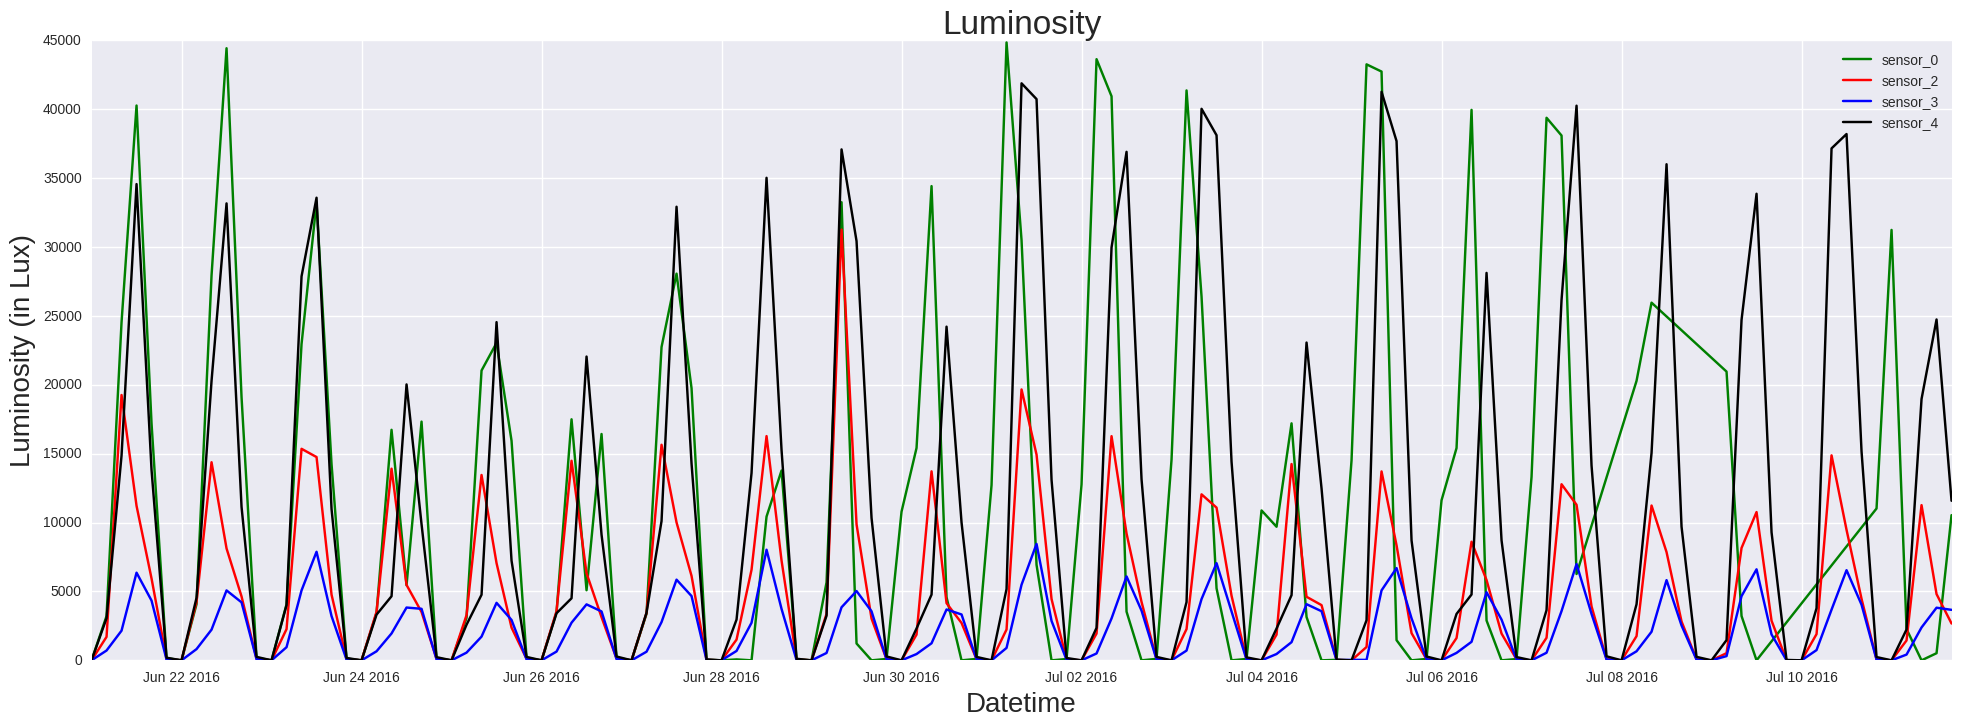

In [8]:
#Ploting lux data
plt.figure(figsize=(24,8))
plt.plot(sensor_0['dt'],sensor_0['lux'], c='green', label='sensor_0')
plt.plot(sensor_2['dt'],sensor_2['lux'], c='red', label='sensor_2')
plt.plot(sensor_3['dt'],sensor_3['lux'], c='blue', label='sensor_3')
plt.plot(sensor_4['dt'],sensor_4['lux'], c='k', label='sensor_4')
plt.title("Luminosity", size=24)
plt.xlabel("Datetime", size=20)
plt.ylabel("Luminosity (in Lux)", size=20)
plt.legend()

#### Figure 1: Luminosity levels have a 24 hour cycle. Sensor_0 and Sensor_4 which are placed at higher elevations get more solar access thus record higher lux levels. Sensor_2 and Sensor_3 that are located at ground and street levels respectively seem to be shaded most of the day. 

## Particulate pollution analysis

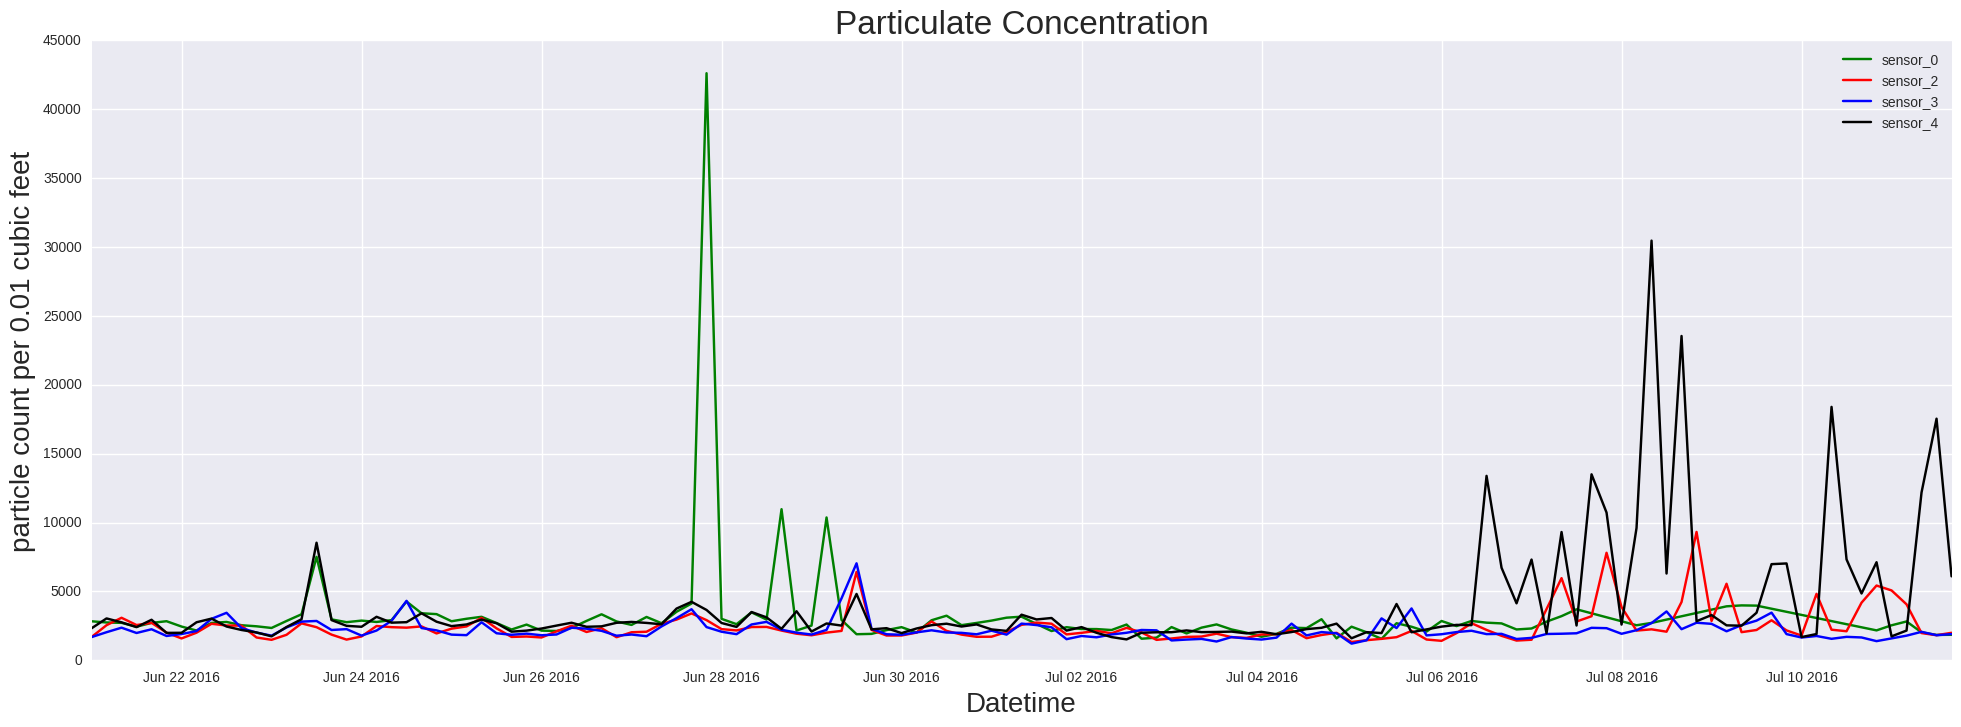

In [9]:
#Ploting air pollution data
plt.figure(figsize=(24,8))
plt.plot(sensor_0['dt'],sensor_0['con'], c='green', label='sensor_0')
plt.plot(sensor_2['dt'],sensor_2['con'], c='red', label='sensor_2')
plt.plot(sensor_3['dt'],sensor_3['con'], c='blue', label='sensor_3')
plt.plot(sensor_4['dt'],sensor_4['con'], c='k', label='sensor_4')
plt.title("Particulate Concentration", size=24)
plt.xlabel("Datetime", size=20)
plt.ylabel("particle count per 0.01 cubic feet", size=20)
plt.legend()

In [10]:
# defining 95% confidence interval range for sensor_0
mean_s0c = np.mean(sensor_0['con'])
std_s0c = np.std(sensor_0['con'])
threshold_s0 = [mean_s0c + 1.96 * std_s0c, mean_s0c - 1.96 * std_s0c]
threshold_s0

# anomalous activity dedection 

sensor_0[sensor_0['con'] > threshold_s0[0]]

,dt,sensor,lux,con,spl,TemperatureF,Humidity
164,2016-06-27 20:00:00,sensor_0,44.000,42612.265,76.766054,78.8,65.0
184,2016-06-28 16:00:00,sensor_0,13774.375,10970.135,75.213957,71.6,94.0


In [11]:
# examining the correlation between particular matter concentrations and temperature, humidity, and land use.
rh_s0 = smf.ols(formula = 'con ~ Humidity', data = sensor_0).fit()
rh_s0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    con   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.7530
Date:                Mon, 17 Apr 2017   Prob (F-statistic):              0.389
Time:                        18:59:58   Log-Likelihood:                -694.06
No. Observations:                  70   AIC:                             1392.
Df Residuals:                      68   BIC:                             1397.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1901.6340   2085.117      0.912      0.365     -2259.153  6062.421
Humidity      27.6009     31.806      0.868      0.389       -35.868    91.069
==============================================================================
Omnibus:                      141.849   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9146.934
Skew:                           7.227   Prob(JB):                         0.00
Kurtosis:                      57.104   Cond. No.                         230.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
# examining the correlation between particular matter concentrations and temperature, humidity, and land use.
tem_s0 = smf.ols(formula = 'con ~ TemperatureF', data = sensor_0).fit()
tem_s0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    con   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                  0.007213
Date:                Mon, 17 Apr 2017   Prob (F-statistic):              0.933
Time:                        18:59:58   Log-Likelihood:                -694.44
No. Observations:                  70   AIC:                             1393.
Df Residuals:                      68   BIC:                             1397.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept     2914.6767   8515.796      0.342      0.733     -1.41e+04  1.99e+04
TemperatureF     9.5484    112.425      0.085      0.933      -214.793   233.889
==============================================================================
Omnibus:                      140.930   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8816.686
Skew:                           7.156   Prob(JB):                         0.00
Kurtosis:                      56.085   Cond. No.                     1.08e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### The Sensor_0 recorded two very high instances of PM levels on the midnight of June 27 and evening of June 28, but Sensor_3 which is also located at same building but at lower elevation recorded no such instance, therefore it is can be duduced that it was a malfunction or something locally (at the floor where the sensor is placed) happened. 

#### Further PM concentratin on this sensor location seems to have no correlation with temperature and humidity.

In [13]:
# defining 95% confidence interval range for sensor_2
mean_s2c = np.mean(sensor_2['con'])
std_s2c = np.std(sensor_2['con'])
threshold_s2 = [mean_s2c + 1.96 * std_s2c, mean_s2c - 1.96 * std_s2c]
threshold_s2

# anomalous activity dedection 

sensor_2[sensor_2['con'] > threshold_s2[0]]

,dt,sensor,lux,con,spl,TemperatureF,Humidity
205,2016-06-29 12:00:00,sensor_2,9872.000,6415.70250,75.356546,71.6,83.0
393,2016-07-07 08:00:00,sensor_2,12781.750,5965.44375,75.738507,77.0,83.0
403,2016-07-07 20:00:00,sensor_2,88.375,7805.96125,73.556487,84.2,66.0
423,2016-07-08 20:00:00,sensor_2,73.000,9319.34625,73.997845,NaN,NaN
430,2016-07-09 04:00:00,sensor_2,520.500,5558.54750,69.468636,NaN,NaN
450,2016-07-10 04:00:00,sensor_2,1902.750,4825.76500,71.432826,NaN,NaN
463,2016-07-10 20:00:00,sensor_2,67.125,5429.00625,73.009035,NaN,NaN
467,2016-07-11 00:00:00,sensor_2,0.000,5074.41250,69.908496,NaN,NaN


In [14]:
# examining the correlation between particular matter concentrations and temperature, humidity, and land use.
rh_s2 = smf.ols(formula = 'con ~ Humidity', data = sensor_2).fit()
rh_s2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    con   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     4.925
Date:                Mon, 17 Apr 2017   Prob (F-statistic):             0.0297
Time:                        18:59:58   Log-Likelihood:                -599.55
No. Observations:                  72   AIC:                             1203.
Df Residuals:                      70   BIC:                             1208.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1506.2068    423.719      3.555      0.001       661.126  2351.287
Humidity      14.3792      6.479      2.219      0.030         1.456    27.302
==============================================================================
Omnibus:                       76.863   Durbin-Watson:                   1.206
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              615.911
Skew:                           3.272   Prob(JB):                    1.81e-134
Kurtosis:                      15.747   Cond. No.                         232.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
# examining the correlation between particular matter concentrations and temperature, humidity, and land use.
tem_s2 = smf.ols(formula = 'con ~ TemperatureF', data = sensor_2).fit()
tem_s2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    con   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                   0.02720
Date:                Mon, 17 Apr 2017   Prob (F-statistic):              0.869
Time:                        18:59:58   Log-Likelihood:                -601.99
No. Observations:                  72   AIC:                             1208.
Df Residuals:                      70   BIC:                             1213.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept     2685.9058   1687.623      1.592      0.116      -679.952  6051.763
TemperatureF    -3.6587     22.182     -0.165      0.869       -47.900    40.583
==============================================================================
Omnibus:                       77.404   Durbin-Watson:                   1.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              614.839
Skew:                           3.314   Prob(JB):                    3.09e-134
Kurtosis:                      15.689   Cond. No.                     1.04e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### The Sensor_2 recorded 8 very high instances of PM levels of which 7 were recorded between July 7-11. This was also noted by the sensor_4.  No news media records were found suggusting out of ordinary happenings on those dates.

#### Further PM concentratin on this sensor location seems to have no correlation with temperature and humidity.

In [16]:
# defining 95% confidence interval range for sensor_3
mean_s3c = np.mean(sensor_3['con'])
std_s3c = np.std(sensor_3['con'])
threshold_s3 = [mean_s3c + 1.96 * std_s3c, mean_s3c - 1.96 * std_s3c]
threshold_s3

# anomalous activity dedection 

sensor_3[sensor_3['con'] > threshold_s3[0]]

,dt,sensor,lux,con,spl,TemperatureF,Humidity
86,2016-06-24 12:00:00,sensor_3,3831.875,4316.28500,81.082485,69.8,68.0
162,2016-06-27 16:00:00,sensor_3,4665.750,3708.80750,77.130408,78.8,57.0
202,2016-06-29 08:00:00,sensor_3,3850.000,4500.10250,80.275216,69.8,94.0
206,2016-06-29 12:00:00,sensor_3,5028.000,7042.19375,80.170259,71.6,83.0
354,2016-07-05 16:00:00,sensor_3,3048.375,3766.22500,78.780224,NaN,NaN


In [17]:
# examining the correlation between particular matter concentrations and temperature, humidity, and land use.
rh_s3 = smf.ols(formula = 'con ~ Humidity', data = sensor_3).fit()
rh_s3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    con   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     5.023
Date:                Mon, 17 Apr 2017   Prob (F-statistic):             0.0282
Time:                        18:59:58   Log-Likelihood:                -579.49
No. Observations:                  72   AIC:                             1163.
Df Residuals:                      70   BIC:                             1168.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1611.3506    320.678      5.025      0.000       971.779  2250.923
Humidity      10.9901      4.904      2.241      0.028         1.210    20.770
==============================================================================
Omnibus:                       83.480   Durbin-Watson:                   1.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              931.491
Skew:                           3.480   Prob(JB):                    5.36e-203
Kurtosis:                      19.188   Cond. No.                         232.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
# examining the correlation between particular matter concentrations and temperature, humidity, and land use.
tem_s0 = smf.ols(formula = 'con ~ TemperatureF', data = sensor_0).fit()
tem_s0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    con   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                  0.007213
Date:                Mon, 17 Apr 2017   Prob (F-statistic):              0.933
Time:                        18:59:58   Log-Likelihood:                -694.44
No. Observations:                  70   AIC:                             1393.
Df Residuals:                      68   BIC:                             1397.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept     2914.6767   8515.796      0.342      0.733     -1.41e+04  1.99e+04
TemperatureF     9.5484    112.425      0.085      0.933      -214.793   233.889
==============================================================================
Omnibus:                      140.930   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8816.686
Skew:                           7.156   Prob(JB):                         0.00
Kurtosis:                      56.085   Cond. No.                     1.08e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### The Sensor_3 recorded anomalous activities around same time as the sensor_0 (levels at sensor_0 were relatively higher), since both sensors are located at same building but at different elevation, therefore it is can be duduced that it must have been something locally (fire or barbeque at upper levels). 

#### Further PM concentratin on this sensor location seems to have no correlation with temperature and humidity.

In [19]:
# defining 95% confidence interval range for sensor_4
mean_s4c = np.mean(sensor_4['con'])
std_s4c = np.std(sensor_4['con'])
threshold_s4 = [mean_s4c + 1.96 * std_s4c, mean_s4c - 1.96 * std_s4c]
threshold_s4

# anomalous activity dedection 

sensor_4[sensor_4['con'] > threshold_s4[0]]

,dt,sensor,lux,con,spl,TemperatureF,Humidity
375,2016-07-06 12:00:00,sensor_4,28119.750,13388.50000,73.386988,69.8,83.0
402,2016-07-07 16:00:00,sensor_4,14136.125,13499.98500,75.079934,89.6,52.0
416,2016-07-08 08:00:00,sensor_4,15045.750,30462.65750,72.394911,NaN,NaN
422,2016-07-08 16:00:00,sensor_4,9701.250,23540.73000,80.936906,NaN,NaN
455,2016-07-10 08:00:00,sensor_4,37156.500,18395.09500,70.323045,NaN,NaN
477,2016-07-11 08:00:00,sensor_4,18965.500,12186.73375,74.689087,NaN,NaN
481,2016-07-11 12:00:00,sensor_4,24739.125,17538.62250,73.268664,NaN,NaN


In [20]:
# examining the correlation between particular matter concentrations and temperature, humidity, and land use.
rh_s4 = smf.ols(formula = 'con ~ Humidity', data = sensor_4).fit()
rh_s4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    con   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.7808
Date:                Mon, 17 Apr 2017   Prob (F-statistic):              0.380
Time:                        18:59:58   Log-Likelihood:                -660.52
No. Observations:                  72   AIC:                             1325.
Df Residuals:                      70   BIC:                             1330.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2555.7540    988.123      2.586      0.012       585.006  4526.503
Humidity      13.3522     15.110      0.884      0.380       -16.784    43.489
==============================================================================
Omnibus:                       67.498   Durbin-Watson:                   1.337
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              337.550
Skew:                           3.017   Prob(JB):                     5.03e-74
Kurtosis:                      11.724   Cond. No.                         232.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
# examining the correlation between particular matter concentrations and temperature, humidity, and land use.
tem_s4 = smf.ols(formula = 'con ~ TemperatureF', data = sensor_4).fit()
tem_s4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    con   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.748
Date:                Mon, 17 Apr 2017   Prob (F-statistic):              0.190
Time:                        18:59:58   Log-Likelihood:                -660.03
No. Observations:                  72   AIC:                             1324.
Df Residuals:                      70   BIC:                             1329.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept    -1589.3405   3779.047     -0.421      0.675     -9126.412  5947.731
TemperatureF    65.6707     49.672      1.322      0.190       -33.398   164.739
==============================================================================
Omnibus:                       64.237   Durbin-Watson:                   1.398
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              301.967
Skew:                           2.854   Prob(JB):                     2.68e-66
Kurtosis:                      11.251   Cond. No.                     1.04e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### The Sensor_2 recorded 8 very high instances of PM levels of which 7 were recorded between July 7-11. This was also noted by the sensor_4.  No news media records were found suggusting out of ordinary happenings on those dates.

#### Further PM concentratin on this sensor location seems to have no correlation with temperature and humidity.

## Noise analysis

sensor_0 mean noise level is  75.0982318452 db
sensor_2 mean noise level is  73.7969831213 db
sensor_3 mean noise level is  77.6560980453 db
sensor_4 mean noise level is  73.4395930082 db


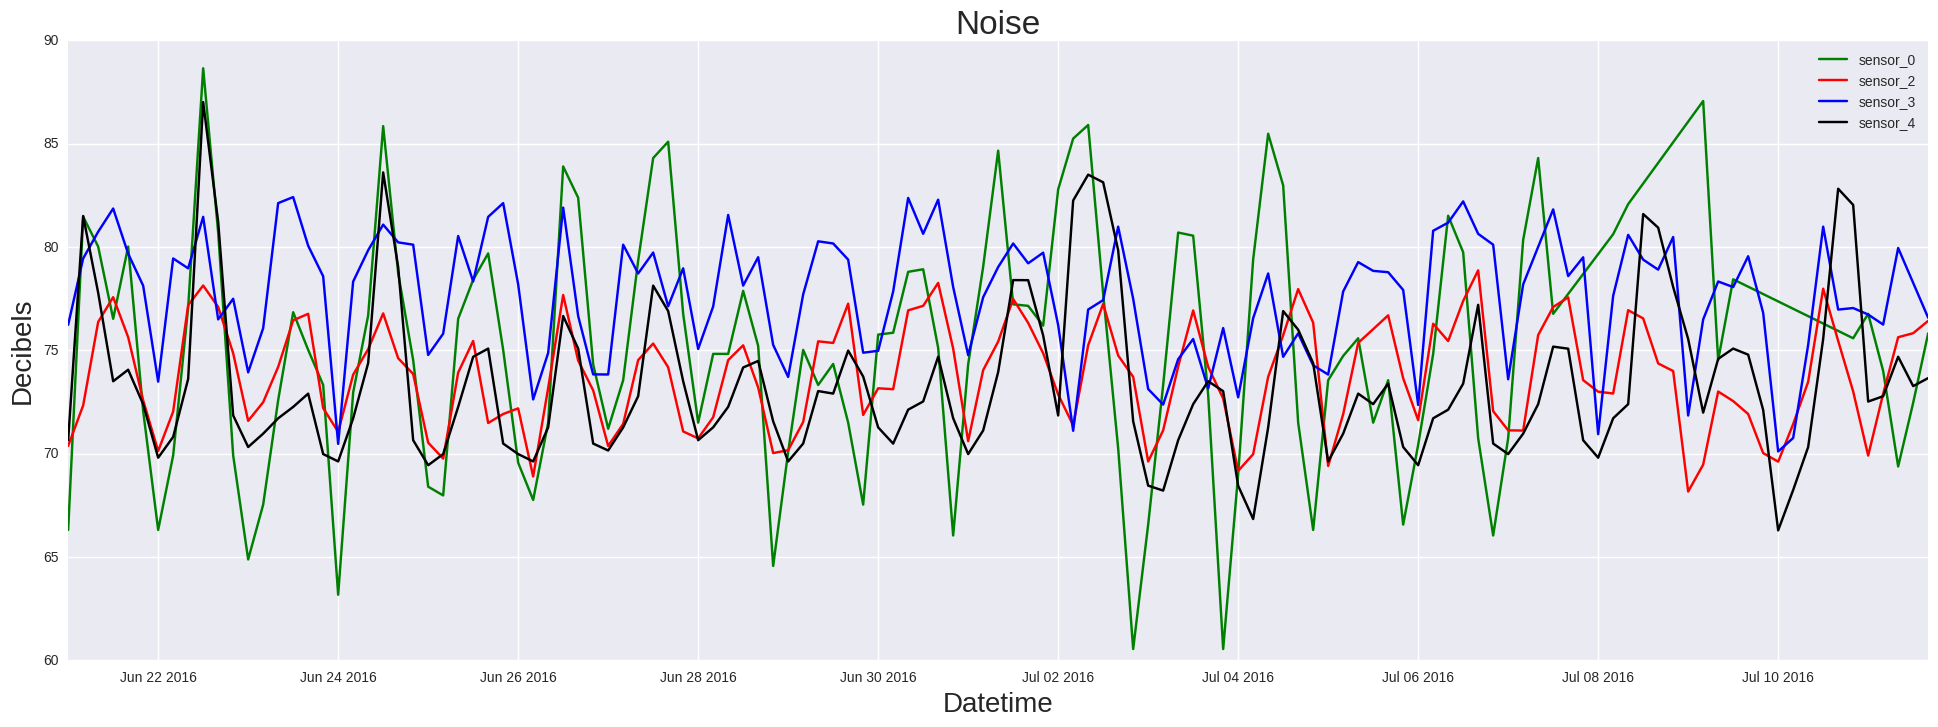

In [22]:
#Calculating mean noise levels

print 'sensor_0 mean noise level is ' , np.mean(sensor_0['spl']), 'db'
print 'sensor_2 mean noise level is ' , np.mean(sensor_2['spl']), 'db'
print 'sensor_3 mean noise level is ' , np.mean(sensor_3['spl']), 'db'
print 'sensor_4 mean noise level is ' , np.mean(sensor_4['spl']), 'db'

#Ploting noise data
plt.figure(figsize=(24,8))
plt.plot(sensor_0['dt'],sensor_0['spl'], c='green', label='sensor_0')
plt.plot(sensor_2['dt'],sensor_2['spl'], c='red', label='sensor_2')
plt.plot(sensor_3['dt'],sensor_3['spl'], c='blue', label='sensor_3')
plt.plot(sensor_4['dt'],sensor_4['spl'], c='k', label='sensor_4')
plt.title("Noise", size=24)
plt.xlabel("Datetime", size=20)
plt.ylabel("Decibels", size=20)
plt.legend()

#### Figure3: Visual analysis of the the noise data shows that there is 24 hourly cyclic pattern in noise level across all 4 sensor locations. Sensor_0 and sensor_3 which are located at same building have highest noise levels, which recording at sensor_0 having higher standard deviation.  

### To understand this further, zoning data from PLUTO is analyzed

In [23]:
#Downloading PLUTO data and unzipping it
#os.system('curl -o ' + 'data/bk_maooluto.zip' + \
#             ' https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/bk_mappluto_16v2.zip')
#zipfile.ZipFile(os.path.join("data/bk_maooluto.zip")).extractall(r"data/bk_maooluto")

In [24]:
#writing shapefile the data onto a geopandas dataframe
shape = GeoDataFrame.from_file('data/bk_maooluto/BKMapPLUTO.shp')
shape = shape.to_crs(epsg=4326) 

#retaining just zipcode 11231 info
shape = pd.concat([shape[shape['ZipCode'] == (11231)]]) 
shape.head()

,APPBBL,APPDate,Address,AreaSource,AssessLand,AssessTot,BBL,BldgArea,BldgClass,BldgDepth,...,YearAlter2,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,geometry
62279,0.0,None,120 DIKEMAN STREET,2,2405.0,9703.0,3.005750e+09,1575,B9,35.0,...,0,1901,None,11231,R5,None,None,None,16a,"POLYGON ((-74.01359740458085 40.6772142197679,..."
62280,0.0,None,134 COFFEY STREET,2,2307.0,7165.0,3.005860e+09,1350,B9,30.0,...,0,1899,None,11231,R5,None,None,None,16a,POLYGON ((-74.01440723856972 40.67689686154324...
62281,0.0,None,405 VAN BRUNT STREET,2,19350.0,515700.0,3.006040e+09,10800,O5,90.0,...,0,2001,None,11231,M1-2,None,None,None,16a,POLYGON ((-74.01453439442366 40.67544605929689...
62282,0.0,None,89 COFFEY STREET,2,20700.0,34650.0,3.005980e+09,1000,M9,50.0,...,0,1931,None,11231,M1-1,None,None,None,16a,POLYGON ((-74.01345523729917 40.67566434745196...
62283,0.0,None,162 COFFEY STREET,2,1886.0,7144.0,3.005850e+09,1800,A5,50.0,...,0,1930,None,11231,M1-1,None,None,None,16a,POLYGON ((-74.01556841502408 40.67741176167203...


In [25]:
#Checking detals of sensor_0 and sensor_3 which are located at 767 HICKS STREET
shape[shape['Address'] == '767 HICKS STREET']

,APPBBL,APPDate,Address,AreaSource,AssessLand,AssessTot,BBL,BldgArea,BldgClass,BldgDepth,...,YearAlter2,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,geometry
64062,3.005350e+09,08/27/2010,767 HICKS STREET,2,47250.0,109800.0,3.005350e+09,4480,E9,80.0,...,0,2008,None,11231,M1-1,None,None,None,16a,POLYGON ((-74.00431237783134 40.67676682179676...


### 767 HICKS STREET is located in a manufacturing zone which explains higher noise levels and high standard deviation. 

In [26]:
#Checking detals of sensor_2 which are located at 106 Ferris St
#sensor_4 : PioneerWorks roof (elevation approx. 15m) - 159 Pioneer St
shape[shape['Address'] == '106 FERRIS STREET']

,APPBBL,APPDate,Address,AreaSource,AssessLand,AssessTot,BBL,BldgArea,BldgClass,BldgDepth,...,YearAlter2,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,geometry
62415,0.0,None,106 FERRIS STREET,2,75150.0,1751400.0,3.005950e+09,73800,E9,161.0,...,0,1920,None,11231,M2-1,None,None,None,16a,POLYGON ((-74.01720420709744 40.67797987643775...


### 106 Ferris St is located in a manufacturing zone which explains higher noise levels

In [27]:
#Checking detals of sensor_4 which are located at 159 Pioneer St
shape[shape['Address'] == 'PIONEER STREET']

,APPBBL,APPDate,Address,AreaSource,AssessLand,AssessTot,BBL,BldgArea,BldgClass,BldgDepth,...,YearAlter2,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,geometry
64010,0.0,None,PIONEER STREET,4,549.0,549.0,3.005460e+09,0,V0,0.0,...,0,0,None,11231,R5,None,None,None,16a,"POLYGON ((-74.0104033935943 40.67806710770461,..."
64146,0.0,None,PIONEER STREET,4,813.0,813.0,3.005460e+09,0,V0,0.0,...,0,0,None,11231,R5,None,None,None,16a,"POLYGON ((-74.01025588108369 40.67799567119, -..."
64163,0.0,None,PIONEER STREET,4,3530.0,3530.0,3.005460e+09,0,V2,0.0,...,0,0,None,11231,R5,None,None,None,16a,POLYGON ((-74.01060577206934 40.67851897067002...


### Pioneer St is located in a residential zone which explains relatively lower noise levels

## Analyzing noise data with 311 noise complaints

In [28]:
#Sensor coordinates via google
sen_2 = (-74.0176610, 40.6779630)
sen_3 = (-74.0044647, 40.6767795)
sen_4 = (-74.0121745, 40.6792043)

#Converting coordinates to shapely geometry
geo2 = gpd.GeoSeries(shp.geometry.Point(sen_2))
geo3 = gpd.GeoSeries(shp.geometry.Point(sen_3))
geo4 = gpd.GeoSeries(shp.geometry.Point(sen_4))

#Defining geodataframe 
sen_loc = pd.DataFrame.from_dict({'sen2': geo2, 'sen3': geo3, 'sen4': geo4}, orient = 'index') 
sen_loc.columns = ['location']
sen_geo = GeoDataFrame(sen_loc, geometry=sen_loc.location) 
sen_geo.reset_index(inplace=True)
sen_geo

,index,location,geometry
0,sen2,POINT (-74.017661 40.677963),POINT (-74.017661 40.677963)
1,sen3,POINT (-74.0044647 40.6767795),POINT (-74.0044647 40.6767795)
2,sen4,POINT (-74.0121745 40.6792043),POINT (-74.0121745 40.6792043)


In [29]:
#uploading 311 noise complaint data from zipcode 11231
df_311 = pd.read_csv('data/311_Service_Requests.csv')
df_311.columns

Index([u'Unique Key', u'Created Date', u'Closed Date', u'Agency',
       u'Agency Name', u'Complaint Type', u'Descriptor', u'Location Type',
       u'Incident Zip', u'Incident Address', u'Street Name', u'Cross Street 1',
       u'Cross Street 2', u'Intersection Street 1', u'Intersection Street 2',
       u'Address Type', u'City', u'Landmark', u'Facility Type', u'Status',
       u'Due Date', u'Resolution Description',
       u'Resolution Action Updated Date', u'Community Board', u'Borough',
       u'X Coordinate (State Plane)', u'Y Coordinate (State Plane)',
       u'Park Facility Name', u'Park Borough', u'School Name',
       u'School Number', u'School Region', u'School Code',
       u'School Phone Number', u'School Address', u'School City',
       u'School State', u'School Zip', u'School Not Found',
       u'School or Citywide Complaint', u'Vehicle Type',
       u'Taxi Company Borough', u'Taxi Pick Up Location',
       u'Bridge Highway Name', u'Bridge Highway Direction', u'Road Ramp',

In [30]:
#selecting relevent information
df_311 = df_311[['Created Date', 'Complaint Type', 'Descriptor','Incident Address', 'Street Name', 'Latitude', 'Longitude']]
df_311.head()

,Created Date,Complaint Type,Descriptor,Incident Address,Street Name,Latitude,Longitude
0,06/20/2016 10:04:21 PM,Noise - Residential,Loud Music/Party,70 BUSH STREET,BUSH STREET,40.675008,-74.006644
1,06/21/2016 02:14:50 PM,Noise - Commercial,Banging/Pounding,175 DIKEMAN STREET,DIKEMAN STREET,40.678254,-74.015712
2,06/21/2016 01:39:00 PM,Noise,Noise: Alarms (NR3),39 COFFEY STREET,COFFEY STREET,40.674585,-74.011727
3,06/22/2016 08:10:56 AM,Noise - Commercial,Banging/Pounding,SMITH STREET,SMITH STREET,40.681955,-73.993698
4,06/23/2016 10:40:46 AM,Noise - Commercial,Car/Truck Horn,175 DIKEMAN STREET,DIKEMAN STREET,40.678254,-74.015712


In [31]:
#writing 311 data to a geopandas dataframe
geometry = [Point(xy) for xy in zip(df_311.Longitude, df_311.Latitude)]
df_311 = df_311.drop(['Longitude', 'Latitude'], axis=1)
crs = {'init': 'epsg:4326'}
geo_311 = GeoDataFrame(df_311, crs=crs, geometry=geometry)
geo_311.head()

,Created Date,Complaint Type,Descriptor,Incident Address,Street Name,geometry
0,06/20/2016 10:04:21 PM,Noise - Residential,Loud Music/Party,70 BUSH STREET,BUSH STREET,POINT (-74.00664420030702 40.67500778066339)
1,06/21/2016 02:14:50 PM,Noise - Commercial,Banging/Pounding,175 DIKEMAN STREET,DIKEMAN STREET,POINT (-74.0157117930007 40.67825396779016)
2,06/21/2016 01:39:00 PM,Noise,Noise: Alarms (NR3),39 COFFEY STREET,COFFEY STREET,POINT (-74.01172731770291 40.67458467948902)
3,06/22/2016 08:10:56 AM,Noise - Commercial,Banging/Pounding,SMITH STREET,SMITH STREET,POINT (-73.99369762776111 40.68195482217686)
4,06/23/2016 10:40:46 AM,Noise - Commercial,Car/Truck Horn,175 DIKEMAN STREET,DIKEMAN STREET,POINT (-74.0157117930007 40.67825396779016)


In [32]:
# flitered data from http://chriswhong.github.io/plutoplus/#
zipfile.ZipFile(os.path.join("data/pluto.zip")).extractall(r"data/pluto")
#writing shapefile the data onto a geopandas dataframe
shape1 = GeoDataFrame.from_file('data/pluto/pluto.shp')
shape1 = shape1.to_crs(epsg=4326) 
shape1.head()

,geometry,landuse
0,POLYGON ((-74.00045515915966 40.67544127989433...,04
1,"POLYGON ((-73.9924124702557 40.67841174587829,...",01
2,POLYGON ((-73.98932383329733 40.68044159060733...,04
3,POLYGON ((-74.01631535593025 40.67973077016901...,10
4,POLYGON ((-74.01413102191485 40.67643537019269...,11


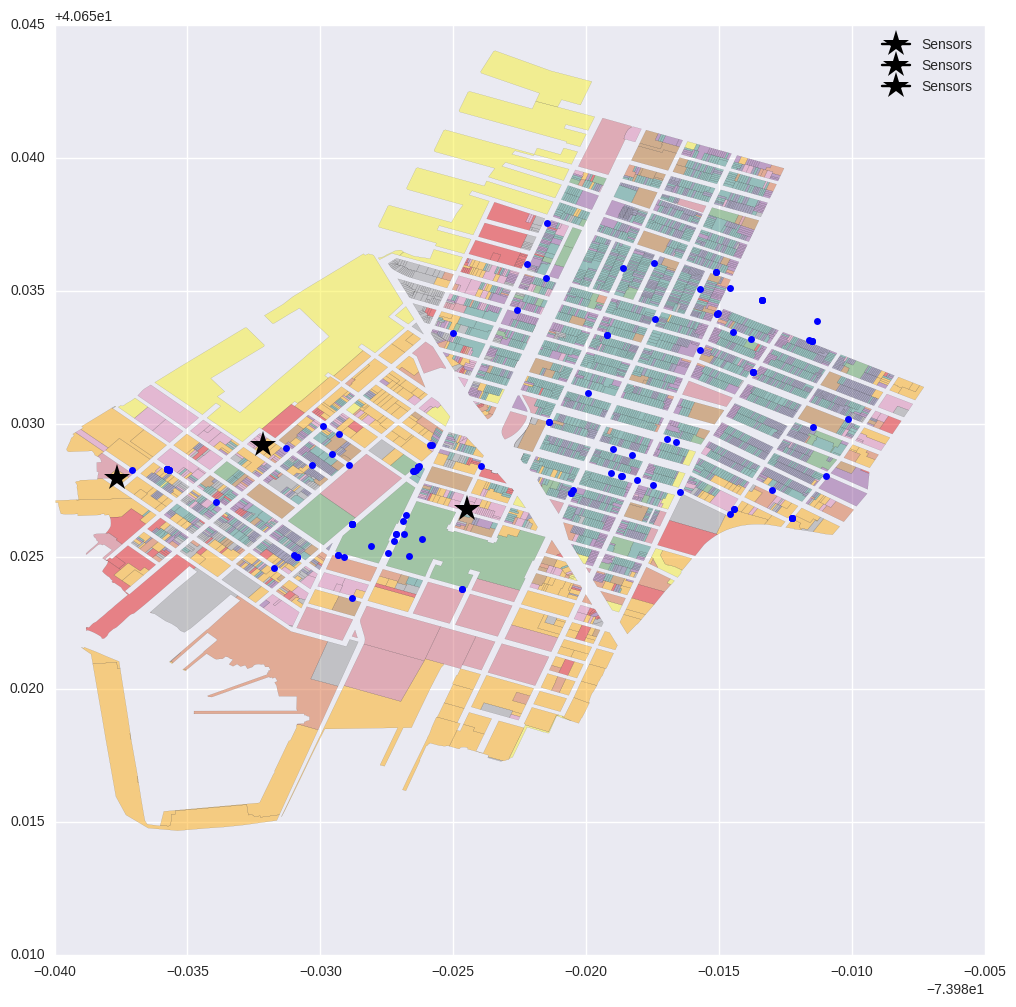

In [37]:
#Ploting to see spatial relationship between sensor locations and 311 noise complaints

f, (ax1) = plt.subplots(figsize=(12,12))
shape1.plot(column='landuse', alpha=0.5, linewidth=0.05, ax=ax1)
geo_311.plot(color= 'blue', marker='o', markersize=5, ax=ax1)
sen_geo.plot(marker='*', color='k', markersize=20, ax=ax1, label = 'Sensors')
plt.legend()


#### Figure4: 311 data from the same time span as the sensor data shows no spatial correlation except one report next to Sensor_2, but further investigation reveals that this particular 311 complaint was not temporally related to high noise levels recorded by the sensor_2. It seems that the neighborhoods where these sensors are located are pretty noisy to start with and not particularly residential by nature therefore 311 complaints are not a good measure to establish severity of noise pollution.